In [1]:
!pip uninstall -y tensorflow tensorflow-cpu
!git clone https://github.com/Aman-Yadav-PY/Vision-Transformer-Model.git
import os
os.chdir("Vision-Transformer-Model")

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Cloning into 'Vision-Transformer-Model'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 125 (delta 62), reused 88 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (125/125), 3.64 MiB | 10.20 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [2]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import Food101
from torchvision.transforms import transforms
from torch.utils.data import random_split
from modelpipe import HybridVitNet

from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
ds_path = "/kaggle/input/food101"
generator = torch.Generator(device='cpu')

image_size = (512, 512)
batch_size = 70

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available Device: ", device)

Available Device:  cuda


In [4]:
normalizer = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )

train_transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(),  normalizer])

test_transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(),  normalizer])

trainset = Food101(ds_path,split='train', transform=train_transform)
testset = Food101(ds_path, split='test', transform=test_transform)

In [5]:
def train_test_split(dataset, factor):
    length= int(0.06* len(dataset))
    remaining = len(dataset) - length
    datasetA, datasetB = random_split(dataset, [length, remaining], generator=generator)
    print("Splited Datset Lengths:", (len(datasetA), len(datasetB)))
    return datasetA,datasetB


def data_loader(dataset, shuffle=True, batch_size=batch_size, num_workers=2, prefetch_factor=2, pin_memory=True):
    return DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=2, prefetch_factor=2, pin_memory=True)


In [6]:
train_loader = data_loader(trainset)
test_loader = data_loader(testset, shuffle=False)

In [7]:
strainset, _= train_test_split(trainset, 0.06)
stestset, _ = train_test_split(testset, 0.06)

Splited Datset Lengths: (4545, 71205)
Splited Datset Lengths: (1515, 23735)


In [8]:
strainloader = data_loader(strainset)
stestloader = data_loader(stestset, shuffle=False)

In [9]:
CLASSES = 101
model = HybridVitNet(num_classes=CLASSES).to(device)
model.initialize_weights()
total_params = 0

for params in model.parameters():
    if params.requires_grad:
        total_params += params.flatten().shape[0]

total_params = total_params/1_000_000
print(f"Trainable Params:{total_params:0.1f}M")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 186MB/s]


Trainable Params:75.4M


In [10]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
def validation_loss (model, test_data, loss_fn, device):
    model.eval()

    batch_loss = 0
    sample_count = 0
    with torch.no_grad():
        for x, y in tqdm(test_data):
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            loss =  loss_fn(out, y)
            batch_loss += loss.item()
            sample_count += 1

    return batch_loss/sample_count


def model_trainer(model, trainset, testset, epoch, loss_fn, optimizer_fn, save_path=None, device=None, validator=None):
    Loss = []
    ValLoss = []

    for ep in range(epoch):
        model.train()
        batch_loss = 0
        sample_count = 0
        for x, y in tqdm(trainset, desc=f"Epoch {ep+1}"):
            x = x.to(device)
            y = y.to(device)
            optimizer_fn.zero_grad()
            
            out = model(x)
            loss = loss_fn(out, y)
    
    
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer_fn.step()
    
            sample_count+=1
            batch_loss += loss.detach().item()
            
        epoch_loss = batch_loss/sample_count
        Loss.append(epoch_loss)
        val_loss = validator(model, testset, loss_fn, device)
        ValLoss.append(val_loss)
        print(f"Loss: {epoch_loss:0.4f} | Val Loss: {val_loss:0.3f}")

    return {"loss":Loss, "val_loss":ValLoss}
        

In [12]:
EPOCH = 100
history = model_trainer(model, strainloader, stestloader, EPOCH, \
                        criterion, optimizer, validator=validation_loss, device=device)


100%|██████████| 22/22 [00:23<00:00,  1.08s/it]


Loss: 4.6155 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6153 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6151 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6151 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6158 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6152 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6148 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6148 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6150 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6147 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6147 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6144 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6143 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6144 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6143 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6143 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6141 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6141 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6141 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6141 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6141 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6141 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6141 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6141 | Val Loss: 4.615


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6142 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6141 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6141 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6140 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6139 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6138 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Loss: 4.6137 | Val Loss: 4.616


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

Loss: 4.6137 | Val Loss: 4.616


In [13]:
history

{'loss': [4.615498814216027,
  4.615273879124568,
  4.615104015056904,
  4.615118848360502,
  4.615796294579139,
  4.6152201872605545,
  4.614826055673452,
  4.614818873772254,
  4.615005427140456,
  4.614652237525353,
  4.6146678997920105,
  4.614431073115422,
  4.614268926473764,
  4.614442304464487,
  4.6143209384037895,
  4.614259433746338,
  4.614111460172213,
  4.614124151376577,
  4.614145080859845,
  4.614143342238206,
  4.6140756900493916,
  4.614108621157133,
  4.6140685374920185,
  4.614070804302509,
  4.614042707589957,
  4.614171270223764,
  4.614088527972882,
  4.614024052253137,
  4.613961755312406,
  4.614006871443529,
  4.613943312718318,
  4.614061370262733,
  4.614032965440017,
  4.613940679110014,
  4.614022012857291,
  4.613910300915058,
  4.6140258202185995,
  4.613936629662147,
  4.613937598008376,
  4.61398166509775,
  4.613899142925556,
  4.613954331324651,
  4.6138726821312535,
  4.61386503806481,
  4.613924195216252,
  4.613848253396841,
  4.613911188565767,


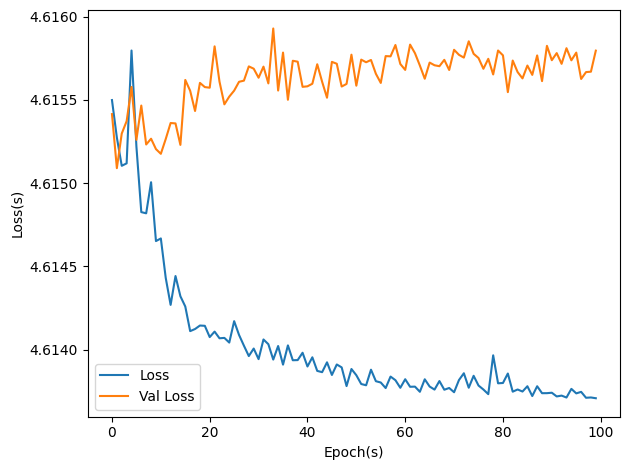

In [14]:
def loss_curve(losses):
    loss = losses['loss']
    val_loss = losses['val_loss']
    
    plt.plot(range(len(loss)), loss, label="Loss")
    plt.plot(range(len(val_loss)), val_loss, label="Val Loss")
    
    plt.xlabel("Epoch(s)")
    plt.ylabel("Loss(s)")
    

    plt.tight_layout()
    plt.legend()
    plt.show()

loss_curve(history)